In [1]:
import os
import sys
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats, fftpack
from glob import glob
import mne

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Functions

In [5]:
# get event triggered firing rates USING find_nearest_ind
# much faster than original
def get_evoked_traces(data, timestamps, events, plot_before, plot_after, data_sample_rate):
    pre_inds = int(plot_before * data_sample_rate)
    post_inds = int(plot_after * data_sample_rate)
    timex = (np.arange(-pre_inds, post_inds) / data_sample_rate)
    
    evoked_traces = np.zeros((len(timex), np.shape(data)[1], len(events)))
    for j, jtime in enumerate(events):
        zeroind = find_nearest_ind(timestamps, jtime)
        data_inds = np.arange(zeroind-pre_inds, zeroind+post_inds)
        evoked_traces[:,:,j] = data[data_inds,:]
    
    return evoked_traces, timex

In [6]:
### voltage threshold = 1000 and trial fraction thresh = 10% appear to do an ok job ###
def get_chquality_allsweeps(exp_inst):
    HI_NOISE_THRESH = 100.0 # default = 50.0 from Npx pipeline analysis
    LO_NOISE_THRESH = 3.0 # default = 3.0 from Npx pipeline analysis
    EARLY_RESPONSE_WINDOW = [0.001, 0.1] # looking in window from 1 to 100 ms for high absolute voltage
    VOLTAGE_THRESH = 1000 # uV
    TRIAL_FRACTION_THRESH = 0.1 # if more than 10% of trials exceed the VOLTAGE_THRESH, it is considered a bad ch

    if exp_inst.experiment_type == 'spontaneous':
        print('This experiment has no stimuli.')
        return
    
    ## Load eeg data and stim log ##
    expstimlog = pd.read_csv(exp_inst.stimulus_log_file)
    eegdata, eegts = exp_inst.load_eegdata()
    ## Cycle through all stim in all sweeps to get traces ##
    channel_dict = {}
    for st_type in np.sort(expstimlog.stim_type.unique()):
        channel_dict[st_type] = {}
        param_list = np.sort(expstimlog[expstimlog['stim_type']==st_type].parameter.unique())
        for parami in param_list:
            channel_dict[st_type][parami] = {}
            sweep_list = np.sort(expstimlog[(expstimlog['stim_type']==st_type) & (expstimlog['parameter']==parami)].sweep.unique())
            for sweepi in sweep_list:
                bad_channel_list = []
                ## Get event times and traces ##
                events = get_stim_events(expstimlog, st_type, parami, sweepi, remove_bad_epochs=False)
                event_traces, event_ts = get_evoked_traces(
                        eegdata,
                        eegts,
                        events,
                        1.0,
                        1.0,
                        exp_inst.ephys_params['EEG']['sample_rate']
                    )
                ## RMS of baseline signal ##
                baseline_inds = event_ts < -0.005 # 5 ms before stim delivery
                baseline_rms = np.power(np.mean(np.power(event_traces[baseline_inds, :, :].astype('float32'), 2), 0), 0.5)
                bad_channel_list.append(np.squeeze(np.argwhere(
                    (np.median(baseline_rms, 1) < LO_NOISE_THRESH) |
                    (np.median(baseline_rms, 1) > HI_NOISE_THRESH)
                )))
                ## Max voltage in early response window ##
                early_inds = np.squeeze(np.argwhere((event_ts > EARLY_RESPONSE_WINDOW[0]) & (event_ts < EARLY_RESPONSE_WINDOW[1])))
                early_max_voltage = np.max(np.abs(event_traces[early_inds, :, :]), axis=0)
                bad_channel_list.append(np.squeeze(np.argwhere(
                    np.mean(early_max_voltage > VOLTAGE_THRESH, axis=1) > TRIAL_FRACTION_THRESH
                )))

                bad_channels = np.unique(np.hstack(bad_channel_list))
                good_channels = np.array([x for x in range(eegdata.shape[1]) if x not in bad_channels])
                channel_dict[st_type][parami][sweepi] = [good_channels, bad_channels]
    
    del expstimlog        
    del eegdata
    del eegts
    
    return channel_dict

### Subjects

In [7]:
sub_dirs = {
    '521885': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\estim1_2020-07-09_14-23-49\recording1',
    '521886': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521886\estim1_2020-07-16_13-37-02\recording1',
    '521887': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521887\estimfull_2020-07-30\experiment1\recordingfull',
    '543393': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543393\estim1_2020-08-20_13-24-53\experiment1\recording1',
    '543394': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543394\estim1_2020-08-27_14-32-00\experiment1\recording1',
    '543396': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1',
    '546655': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
#     '543395': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543395\estim1_2020-09-03_13-19-42\experiment1\recording1',
}

## Sweep ids for each brain state
brain_states = {
    '521885': {'awake': [0], 'anesthetized': [1], 'recovery': []},
    '521886': {'awake': [0], 'anesthetized': [1], 'recovery': [2]},
    '521887': {'awake': [0, 1], 'anesthetized': [2, 3, 4], 'recovery': [5, 6, 7]},
    '543393': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5], 'recovery': [6, 7, 8]},
    '543394': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5], 'recovery': [6, 7, 8]},
    '543395': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5, 6], 'recovery': [7, 8, 9]},
    '543396': {'awake': [0], 'anesthetized': [1], 'recovery': [2]},
    '546655': {'awake': [0], 'anesthetized': [1], 'recovery': [2, 3]},
}

## Stim amplitudes for the PCI calculation
PCI_stim_amp = {
    '521885': 50,
    '521886': 50,
    '521887': 20,
    '543393': 70,
    '543394': 50,
    '543395': 60,
    '543396': 80,
    '546655': 70,
}

In [20]:
plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'

### Load experiments

In [9]:
sub_exp = {}
sub_good_bad_chs = {}
for mousei, recdiri in sub_dirs.items():
    print(mousei)
    start = time.time()
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)
    sub_good_bad_chs[mousei] = get_chquality_allsweeps(sub_exp[mousei])
    end = time.time()
    print('Time to get ch quality dict: {:.2f} s'.format(end-start))

521885
Experiment type: electrical stimulation
SomnoSuite log file not found.
Time to get ch quality dict: 7.95 s
521886
Experiment type: electrical stimulation
SomnoSuite log file not found.
Time to get ch quality dict: 15.17 s
521887
Experiment type: electrical stimulation
SomnoSuite log file not found.
Time to get ch quality dict: 14.96 s
543393
Experiment type: electrical stimulation
SomnoSuite log file not found.
Time to get ch quality dict: 16.19 s
543394
Experiment type: electrical stimulation
SomnoSuite log file not found.
Time to get ch quality dict: 18.15 s
543396
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Time to get ch quality dict: 11.06 s
546655
Experiment type: electrical and sensory stimulation
Time to get ch quality dict: 25.68 s


### Load eeg data and gather stim-evoked traces, avg traces, and filtered traces?

In [10]:
## parameters ##
before_event = 1. # s, look at 100 ms pre-stim
after_event = 1. # s, look at 1000 ms post-stim
sttype = 'biphasic' # can be 'fullscreen', 'auditory', or 'biphasic'

low_pass_cutoff = 100
apply_blsub = False

test_states = ['awake', 'anesthetized']

In [11]:
start = time.time()

sub_stim_amps = {}
sub_num_trials = {}
sub_traces = {}
sub_bad_chs = {}
# sub_avg_traces = {}

for mousei, expi in sub_exp.items():
    print(mousei)
    
    # load stim log
    stim_log = pd.read_csv(expi.stimulus_log_file)
    stim_amps = np.sort(stim_log[stim_log['stim_type']==sttype].parameter.unique())
    sub_stim_amps[mousei] = stim_amps
    
    # load data
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(0,datai.shape[1])
    
    # Mask the artifacts
    mask_samples = int(0.002 * expi.ephys_params['EEG']['sample_rate'])
    for etime in stim_log[stim_log['stim_type'] == 'biphasic'].onset.to_numpy():
        val = find_nearest_ind(tsi, etime) - 2
        datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]
    
    # get evoked traces
    sub_traces[mousei] = {}
    sub_num_trials[mousei] = {}
    sub_bad_chs[mousei] = {}
#     sub_avg_traces[mousei] = {}
    
    for statei, sweeps in brain_states[mousei].items():
        if sweeps:
            sub_traces[mousei][statei] = {}
            sub_num_trials[mousei][statei] = {}
            sub_bad_chs[mousei][statei] = {}
#             sub_avg_traces[mousei][statei] = {}
            
            for ampi in stim_amps:
                traces = []
                bad_chs_list = []
                for sweepi in sweeps:
                    events = get_stim_events(stim_log, sttype, ampi, sweepi)
                    if len(events) == 0:
                        print('%s, sweep %d, %s uA: no good trials' % (statei, sweepi, str(ampi)))
                        continue
                    bad_chs_list.append(sub_good_bad_chs[mousei][sttype][ampi][sweepi][1])
                    event_traces, event_ts = get_evoked_traces(
                        datai,
                        tsi,
                        events,
                        before_event,
                        after_event,
                        expi.ephys_params['EEG']['sample_rate']
                    )
                    traces.append(event_traces)
                        
                sub_traces[mousei][statei][str(ampi)] = [event_ts, np.concatenate(traces, axis=2)]
#                 sub_avg_traces[mousei][statei][str(ampi)] = [event_ts, np.mean(np.concatenate(traces, axis=2), axis=2)]
                sub_num_trials[mousei][statei][str(ampi)] = np.shape(sub_traces[mousei][statei][str(ampi)][1])[2]
                sub_bad_chs[mousei][statei][str(ampi)] = np.unique(np.concatenate(bad_chs_list))
            
    del datai
    del tsi
    del stim_log

end = time.time()
print('Time to analyze: {:.2f} min'.format((end - start) / 60))

521885
521886
521887
543393
543394
543396
546655
Time to analyze: 1.37 min


### Calculate PCIst, match trial numbers of states

In [15]:
PCI_params = {
    'baseline_window': (-0.5, -0.005), # s before stim for baseline, my default: (-500, -1)
    'response_window': (0.005, 0.5), # s after stim for response, my default: (1, 500)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

full_PCI_output = {}
sub_PCI_traces = {}
for subject, expi in sub_exp.items():
    print(subject)
    start = time.time()
    
    PCIamp = str(PCI_stim_amp[subject])
    amp_bad_chs = np.unique(np.concatenate([sub_bad_chs[subject][x][PCIamp] for x in test_states]))
    GOOD_CHS = np.array([x for x in eegchs if x not in amp_bad_chs])
    print('Good chs: {:d}'.format(len(GOOD_CHS)))
    NUM_TRIALS = min([sub_num_trials[subject][x][PCIamp] for x in test_states])
    print('Trials: {:d}'.format(NUM_TRIALS))
    
    full_PCI_output[subject] = {}
    sub_PCI_traces[subject] = {}
    for statei in test_states:
        sub_PCI_traces[subject][statei] = {}
        full_PCI_output[subject][statei] = {}
        
        timex = sub_traces[subject][statei][PCIamp][0]
        raw_traces = sub_traces[subject][statei][PCIamp][1]
        
        ## Common average ##
        comavg_traces = raw_traces[:, GOOD_CHS, :] - np.mean(raw_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
        
        ## Filter traces ##
        filtb, filta = signal.butter(3, low_pass_cutoff/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')
        raw_traces = signal.filtfilt(filtb, filta, raw_traces[:, GOOD_CHS, :], axis=0)
        comavg_traces = signal.filtfilt(filtb, filta, comavg_traces, axis=0)
        
        ## Subselect trials and take avg ##
        if statei == 'recovery':
            mean_traces = np.mean(raw_traces[:, :, -NUM_TRIALS:], axis=2)
            mean_comavg_traces = np.mean(comavg_traces[:, :, -NUM_TRIALS:], axis=2)
        else:
            mean_traces = np.mean(raw_traces[:, :, :NUM_TRIALS], axis=2)
            mean_comavg_traces = np.mean(comavg_traces[:, :, -NUM_TRIALS:], axis=2)
        sub_PCI_traces[subject][statei]['acq_ref'] = [timex, mean_traces]
        sub_PCI_traces[subject][statei]['comavg_ref'] = [timex, mean_comavg_traces]
        
        ## Calculate PCIst with full return ##
        full_PCI_output[subject][statei]['acq_ref'] = calc_PCIst(
            mean_traces.T,
            timex,
            full_return=True,
            **PCI_params
        )
        full_PCI_output[subject][statei]['comavg_ref'] = calc_PCIst(
            mean_comavg_traces.T,
            timex,
            full_return=True,
            **PCI_params
        )

#         print('{:s} PCI = {:.3f}'.format(statei, full_PCI_output[subject][statei]['acq_ref']['PCI']))
    end = time.time()
    print('Time: {:.2f} s'.format(end-start))
    print('')

521885
Good chs: 25
Trials: 55
Time: 212.34 s

521886
Good chs: 23
Trials: 84
Time: 127.33 s

521887
Good chs: 26
Trials: 156
Time: 124.88 s

543393
Good chs: 26
Trials: 254
Time: 169.03 s

543394
Good chs: 22
Trials: 281
Time: 121.68 s

543396
Good chs: 23
Trials: 100
Time: 145.90 s

546655
Good chs: 29
Trials: 94
Time: 163.78 s



#### Make butterfly plots for all mice in one figure

<IPython.core.display.Javascript object>


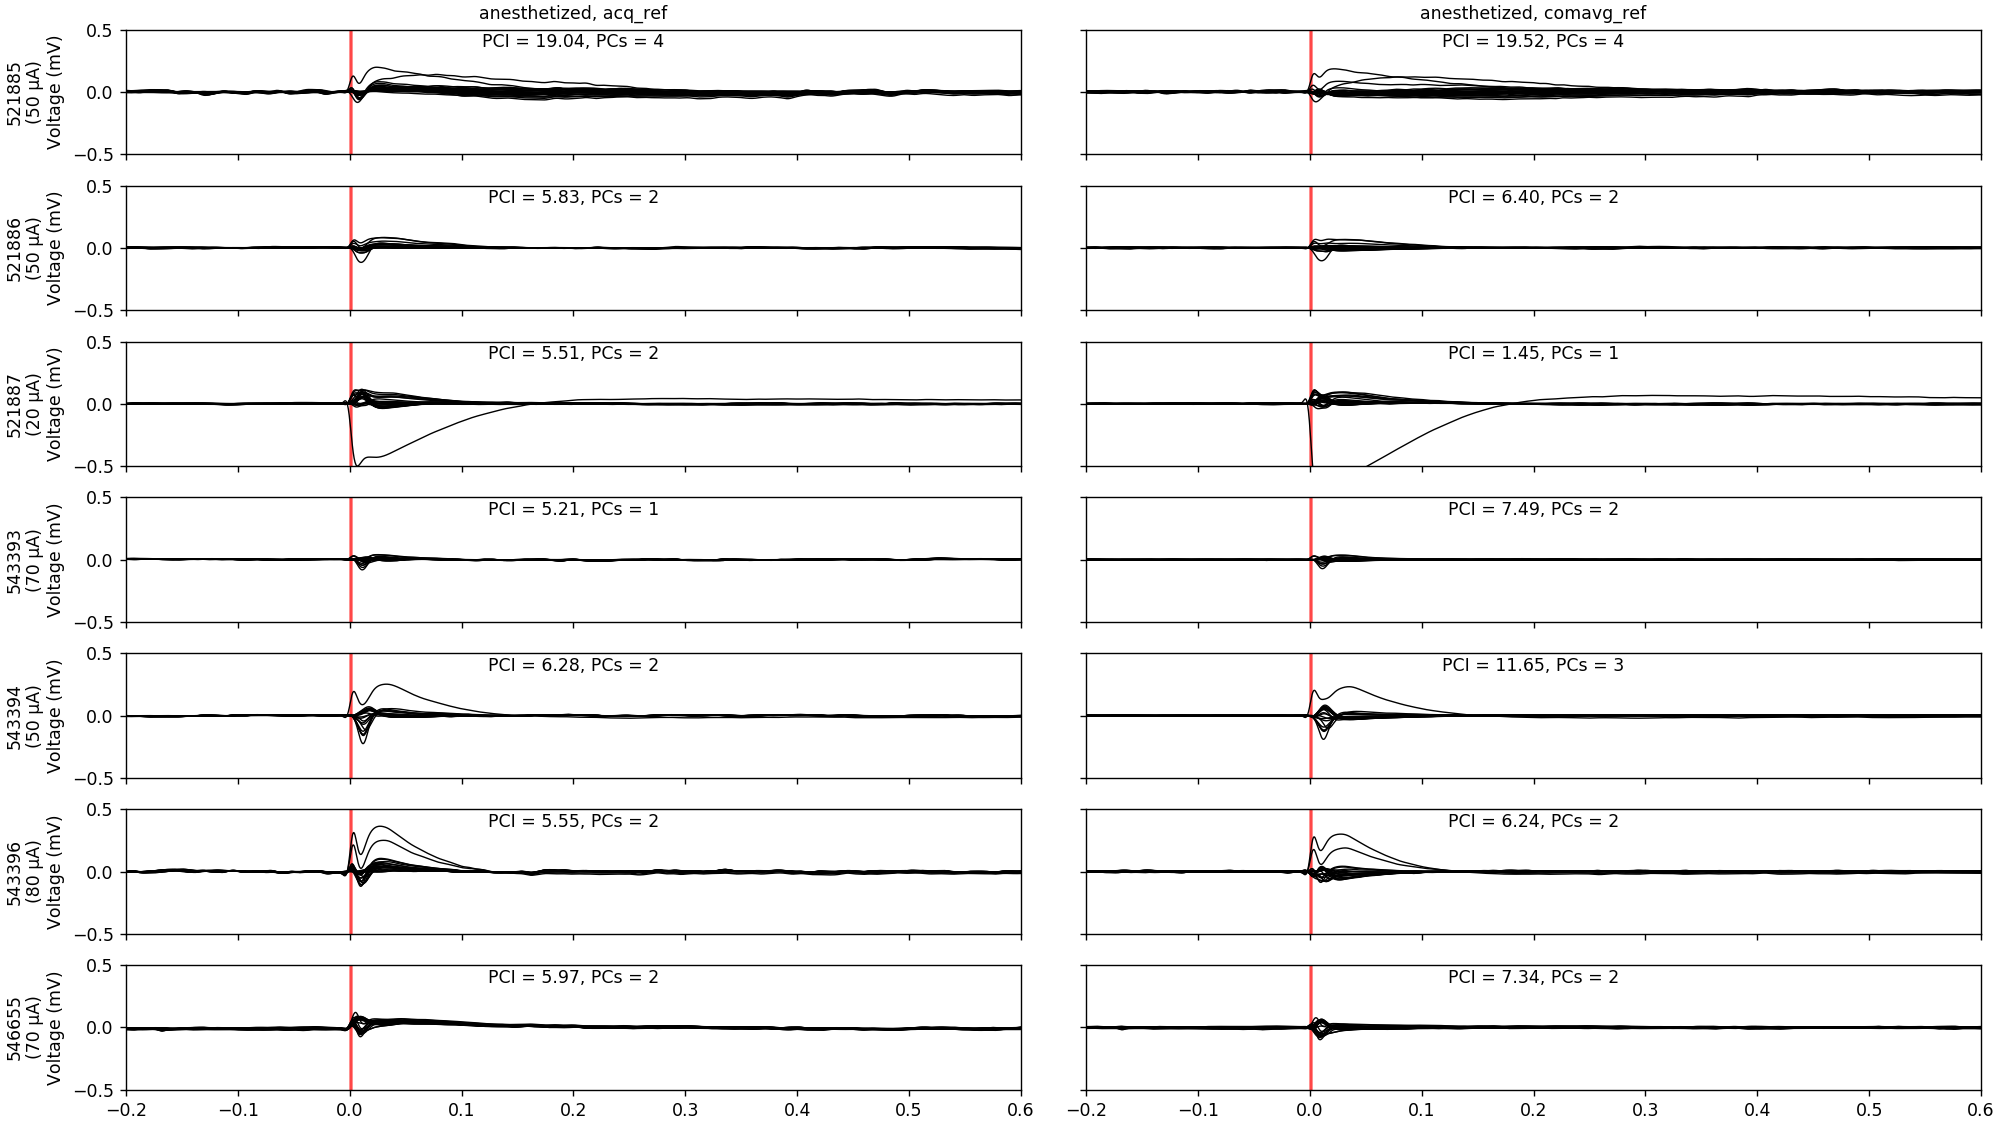

In [25]:
statei = 'anesthetized' # 'awake'
prex = 0.2 # s before stim to plot
postx = 0.6 # s after stim to plot
ylimit = 0.5 # mV

fig, axs = plt.subplots(len(sub_PCI_traces.keys()), 2, figsize=(16, 9), sharex=True, sharey=True, constrained_layout=True)
for row, subject in enumerate(sub_PCI_traces.keys()):

    ## Butterfly figure not including bad chs ##
    for col, refi in enumerate(sub_PCI_traces[subject][statei].keys()):
        pick_traces = sub_PCI_traces[subject][statei][refi][1]/1000 # or sub_avg_traces_filter
        pick_times = sub_PCI_traces[subject][statei][refi][0]
        plot_inds = np.squeeze(np.argwhere((pick_times >= -prex) & (pick_times <= postx)))
        
        axs[row,col].plot(pick_times[plot_inds], pick_traces[plot_inds,:], color='k', linewidth=0.8)
        axs[row,col].axvspan(0, 0.002, color='r', alpha=0.5)

        axs[row,col].text(
            0.5, 0.9,
            ('PCI = {:.2f}, PCs = {:d}'.format(full_PCI_output[subject][statei][refi]['PCI'], full_PCI_output[subject][statei][refi]['n_dims'])),
            horizontalalignment='center',
            verticalalignment='center',
            transform = axs[row,col].transAxes
        )
        if row == 0:
            axs[0,col].set_title(('{:s}, {:s}'.format(statei, refi)), fontsize=10)
    axs[row,0].set_ylabel('{:s}\n({:d} \u03BCA)\nVoltage (mV)'.format(subject, PCI_stim_amp[subject]))

axs[0,0].set_xlim([-prex, postx])
axs[0,0].set_ylim([-ylimit, ylimit])
# axs[-1,:].set_xlabel('Time from stim onset (ms)')


## Save butterfly figure ##
# fig.savefig(os.path.join(plotdir, 'all7mice_evokedEEG_wPCI_ISO_acq-vs-comavg.png'), transparent=True)

<IPython.core.display.Javascript object>


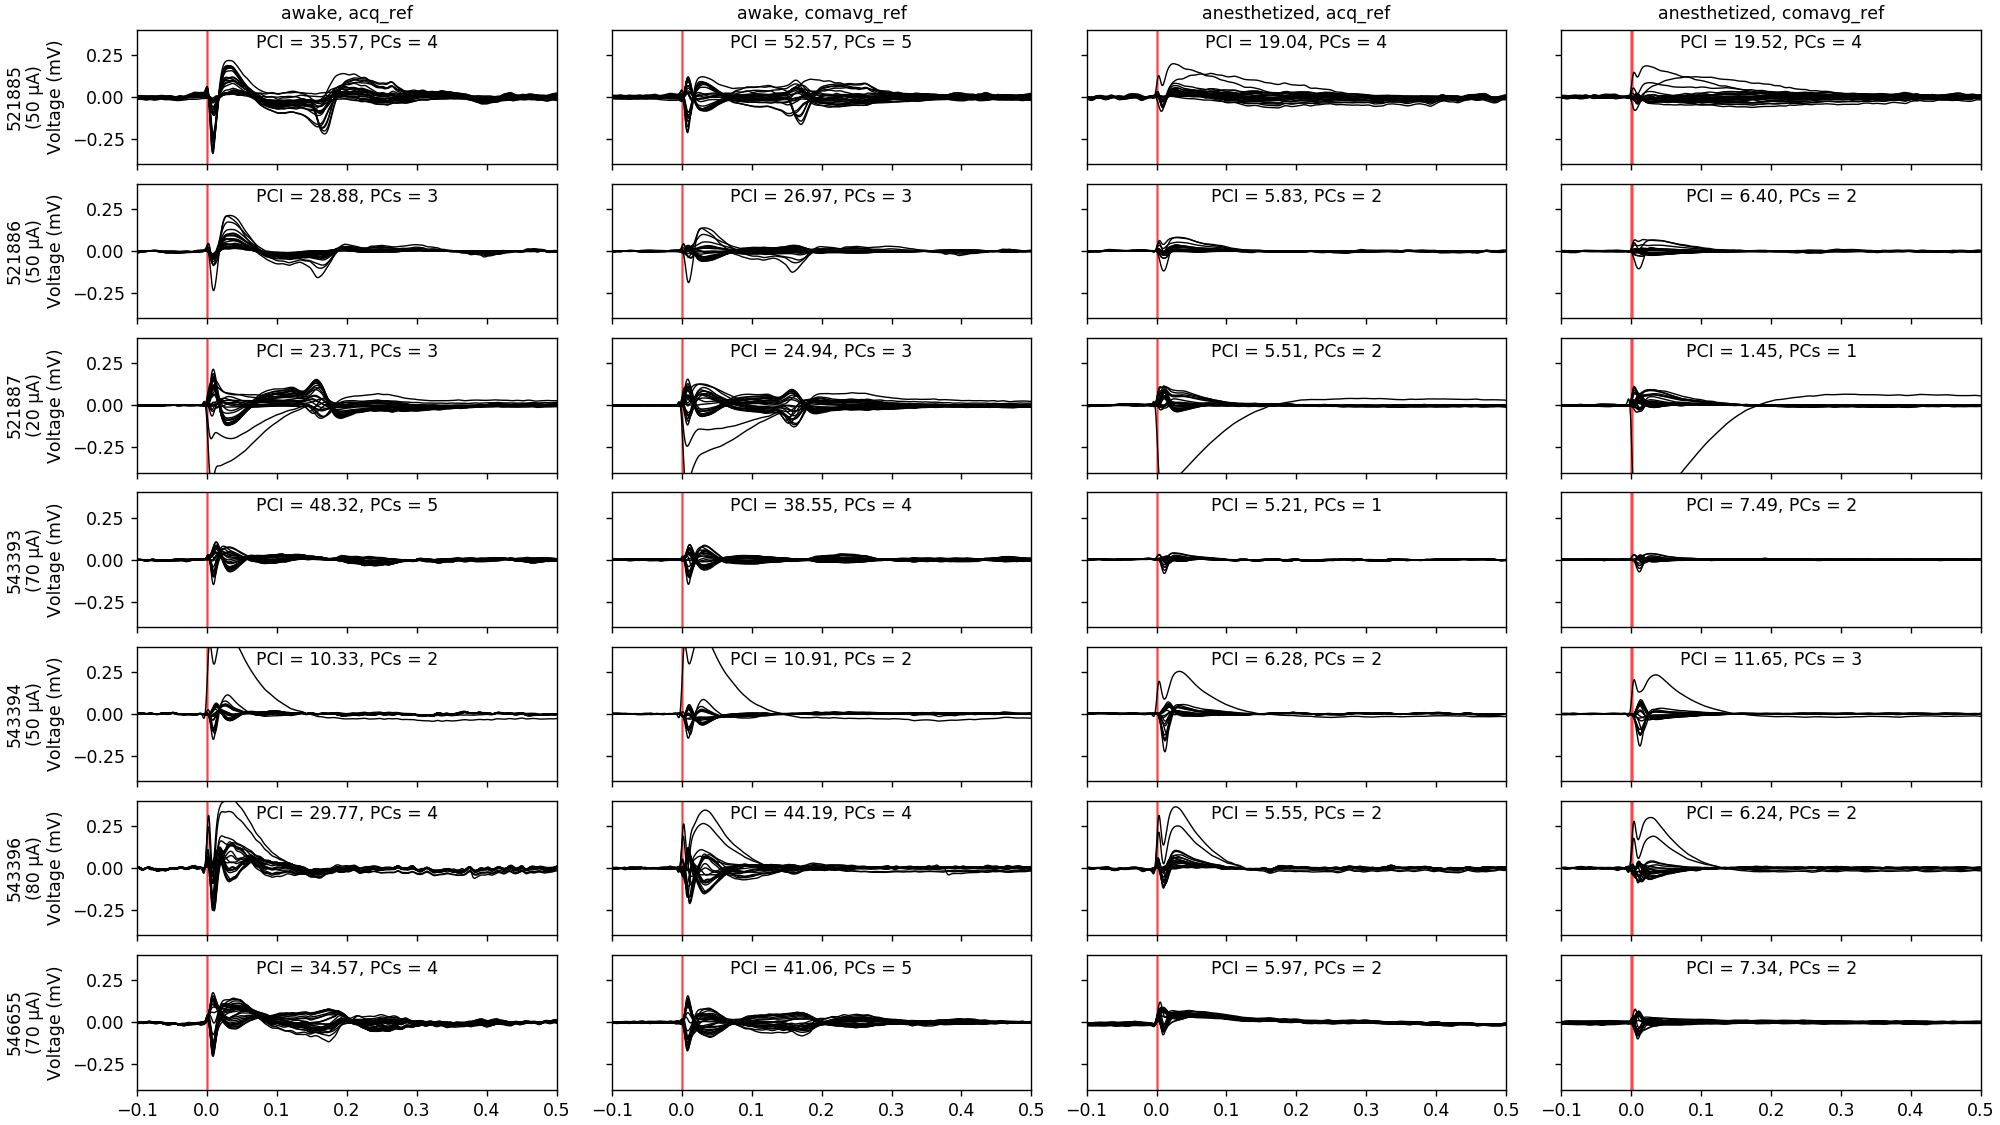

In [30]:
## both states and refs in one figure ##

prex = 0.1 # s before stim to plot
postx = 0.5 # s after stim to plot
ylimit = 0.4 # mV

fig, axs = plt.subplots(len(sub_PCI_traces.keys()), 4, figsize=(16, 9), sharex=True, sharey=True, constrained_layout=True)
for row, subject in enumerate(sub_PCI_traces.keys()):

    ## Butterfly figure not including bad chs ##
    col = 0
    for statei in sub_PCI_traces[subject].keys():
        for refi in sub_PCI_traces[subject][statei].keys():
            pick_traces = sub_PCI_traces[subject][statei][refi][1]/1000 # or sub_avg_traces_filter
            pick_times = sub_PCI_traces[subject][statei][refi][0]
            plot_inds = np.squeeze(np.argwhere((pick_times >= -prex) & (pick_times <= postx)))

            axs[row,col].plot(pick_times[plot_inds], pick_traces[plot_inds,:], color='k', linewidth=0.8)
            axs[row,col].axvspan(0, 0.002, color='r', alpha=0.5)

            axs[row,col].text(
                0.5, 0.9,
                ('PCI = {:.2f}, PCs = {:d}'.format(full_PCI_output[subject][statei][refi]['PCI'], full_PCI_output[subject][statei][refi]['n_dims'])),
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[row,col].transAxes
            )
            if row == 0:
                axs[0,col].set_title(('{:s}, {:s}'.format(statei, refi)), fontsize=10)
            col += 1
    axs[row,0].set_ylabel('{:s}\n({:d} \u03BCA)\nVoltage (mV)'.format(subject, PCI_stim_amp[subject]))

axs[0,0].set_xlim([-prex, postx])
axs[0,0].set_ylim([-ylimit, ylimit])
# axs[-1,:].set_xlabel('Time from stim onset (ms)')


## Save butterfly figure ##
# fig.savefig(os.path.join(plotdir, 'all7mice_EEG_wPCI_acq-vs-comavg.png'), transparent=True)

<IPython.core.display.Javascript object>


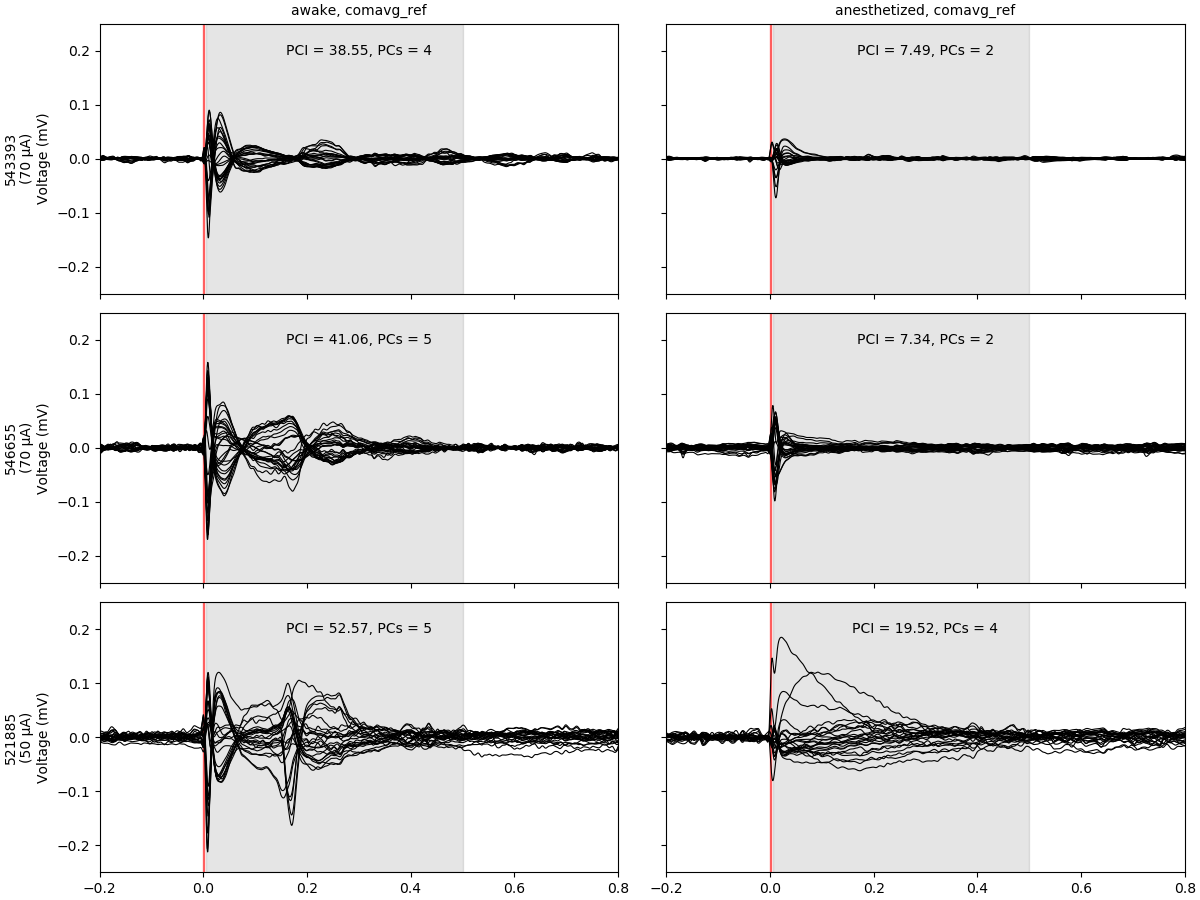

In [38]:
## Plot some mice ##
plot_mice = ['543393', '546655', '521885']
plot_ref = 'comavg_ref'

prex = 0.2 # s before stim to plot
postx = 0.8 # s after stim to plot
ylimit = 0.25 # mV

fig, axs = plt.subplots(len(plot_mice), 2, figsize=(16*.75, 9), sharex=True, sharey=True, constrained_layout=True)
for row, subject in enumerate(plot_mice):

    ## Butterfly figure not including bad chs ##
    for col, statei in enumerate(sub_PCI_traces[subject].keys()):
        pick_traces = sub_PCI_traces[subject][statei][plot_ref][1]/1000 # or sub_avg_traces_filter
        pick_times = sub_PCI_traces[subject][statei][plot_ref][0]
        plot_inds = np.squeeze(np.argwhere((pick_times >= -prex) & (pick_times <= postx)))

        axs[row,col].plot(pick_times[plot_inds], pick_traces[plot_inds,:], color='k', linewidth=0.8)
        axs[row,col].axvspan(0, 0.002, color='r', alpha=0.5)
        axs[row,col].axvspan(0.005, 0.5, color='k', alpha=0.1)

        axs[row,col].text(
            0.5, 0.9,
            ('PCI = {:.2f}, PCs = {:d}'.format(full_PCI_output[subject][statei][plot_ref]['PCI'], full_PCI_output[subject][statei][plot_ref]['n_dims'])),
            horizontalalignment='center',
            verticalalignment='center',
            transform = axs[row,col].transAxes
        )
        if row == 0:
            axs[0,col].set_title(('{:s}, {:s}'.format(statei, plot_ref)), fontsize=10)
    axs[row,0].set_ylabel('{:s}\n({:d} \u03BCA)\nVoltage (mV)'.format(subject, PCI_stim_amp[subject]))

axs[0,0].set_xlim([-prex, postx])
axs[0,0].set_ylim([-ylimit, ylimit])
# axs[-1,:].set_xlabel('Time from stim onset (ms)')


## Save butterfly figure ##
# fig.savefig(os.path.join(plotdir, 'ex3mice_EEG_wPCI_comavg.png'), transparent=True)

## Plot PCI values

In [17]:
sub_PCI_values = {}
for mousei in full_PCI_output.keys():
    sub_PCI_values[mousei] = {}
    for statei in full_PCI_output[mousei].keys():
        sub_PCI_values[mousei][statei] = full_PCI_output[mousei][statei]['acq_ref']['PCI']
        sub_PCI_values[mousei][statei+'_comavg'] = full_PCI_output[mousei][statei]['comavg_ref']['PCI']
pci_df = pd.DataFrame(sub_PCI_values)
PCIvalues = pci_df.to_numpy()
pci_df.head()

,521885,521886,521887,543393,543394,543396,546655
awake,35.572346,28.884587,23.707619,48.323604,10.333184,29.765395,34.574423
awake_comavg,52.573942,26.967558,24.940305,38.545414,10.911403,44.187649,41.058558
anesthetized,19.041485,5.830416,5.505255,5.206648,6.279476,5.549717,5.969622
anesthetized_comavg,19.520110,6.403079,1.452708,7.493891,11.647024,6.236863,7.344380


<IPython.core.display.Javascript object>


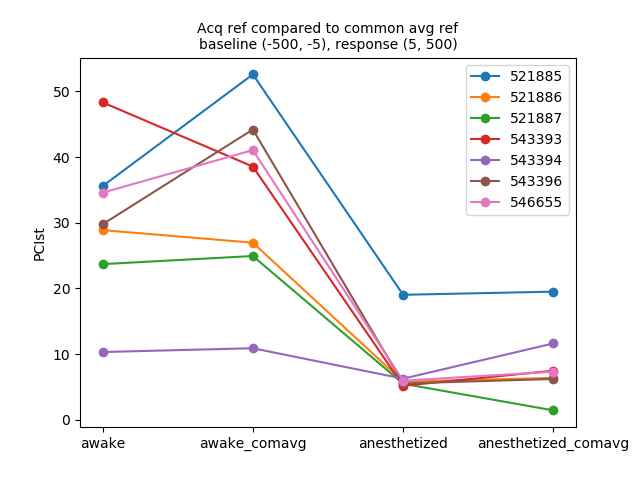

In [22]:
fig, ax = plt.subplots()
ax.plot(
    np.arange(0, PCIvalues.shape[0]),
    PCIvalues,
    marker='o',
)
ax.set_xticks(np.arange(0, PCIvalues.shape[0]))
ax.set_xticklabels(list(pci_df.index.values))
ax.set_ylabel('PCIst')
ax.legend(list(pci_df.columns))
ax.set_title(
    'Acq ref compared to common avg ref\nbaseline ({:.0f}, {:.0f}), response ({:.0f}, {:.0f})'.format(
        PCI_params['baseline_window'][0]*1000,
        PCI_params['baseline_window'][1]*1000,
        PCI_params['response_window'][0]*1000,
        PCI_params['response_window'][1]*1000,
    ))

## Save figure ##
# fig.savefig(os.path.join(plotdir, 'all7mice_PCIst_acq-vs-comavg.png'), transparent=True)

#### Paired t-test
<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel

In [18]:
## Calculate the t-test on TWO RELATED samples of scores, a and b.
t2, p2 = stats.ttest_rel(PCIvalues_eqn[0,:], PCIvalues_eqn[1,:])
print("t = " + str(t2))
print("p = " + str(p2))
### is this a paired ttest???

t = 5.369266368097336
p = 0.0017129888174419038


Wilcoxon signed rank sum test (for non-normal distributions)
<br>The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

<IPython.core.display.Javascript object>


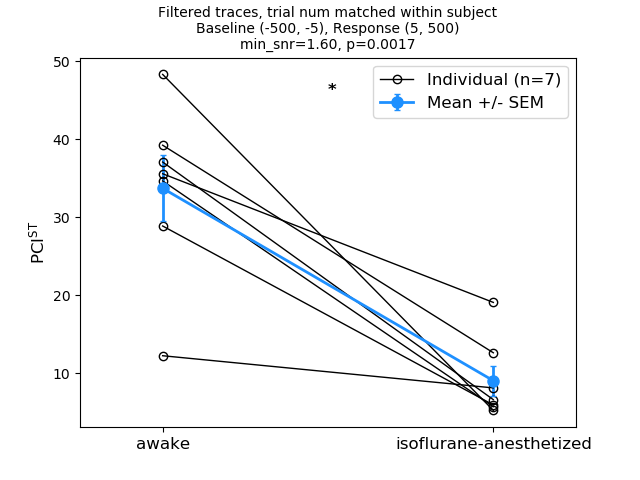

In [30]:
fig, ax = plt.subplots()
# plot individuals with unfilled circles
individs = ax.plot(
    np.arange(0, PCIvalues_eqn.shape[0]),
    PCIvalues_eqn,
    color='k',
    linewidth=1,
    marker='o',
    fillstyle='none'
)
# plot mean +/- SEM with filled circles
mean_sem = ax.errorbar(
    np.arange(0, PCIvalues_eqn.shape[0]),
    np.mean(PCIvalues_eqn, axis=1),
    yerr=stats.sem(PCIvalues_eqn, axis=1),
    color='dodgerblue',
    linewidth=2,
    marker='o',
    markersize=8,
)
# annotate with asterisk
ax.annotate('*', xy=(0.5,0.9), xycoords='axes fraction', fontsize=12, fontweight='bold')

ax.set_xlim([-0.25, 1.25])
ax.set_xticks(np.arange(0, PCIvalues_eqn.shape[0]))
ax.set_xticklabels(['awake', 'isoflurane-anesthetized'], fontsize=12)
ax.set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=12)
ax.legend([individs[0], mean_sem], [('Individual (n={:d})'.format(PCIvalues_eqn.shape[1])), 'Mean +/- SEM'], fontsize=12)
ax.set_title(
    'Filtered traces, trial num matched within subject\nBaseline ({:d}, {:d}), Response ({:d}, {:d})\nmin_snr={:.2f}, p={:.4f}'.format(
        PCI_params['baseline_window'][0],
        PCI_params['baseline_window'][1],
        PCI_params['response_window'][0],
        PCI_params['response_window'][1],
        PCI_params['min_snr'],
        p2
    ))

## Save
# fig.savefig(os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'PCIst_7mice_IRsameparams.png'), transparent=True)

### Plotting other PCI info

<IPython.core.display.Javascript object>


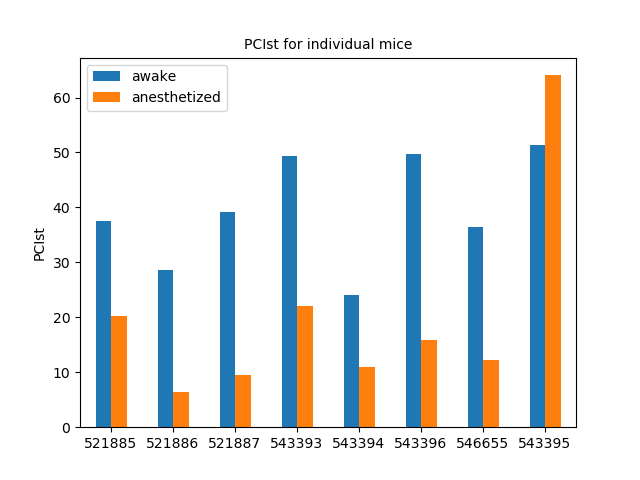

Text(0, 0.5, 'PCIst')

In [34]:
pciax = pci_eqn.T.plot.bar(rot=0)
pciax.set_title('PCIst for individual mice')
pciax.set_ylabel('PCIst')

In [37]:
num_goodchs = [(30 - len(bad_chs[x])) for x in sub_list]
numchsdf = pd.DataFrame({'subjects':sub_list, 'good_chs':num_goodchs})
numchsdf.head()

,subjects,good_chs
0,521885,25
1,521886,23
2,521887,25
3,543393,26
4,543394,21


<IPython.core.display.Javascript object>


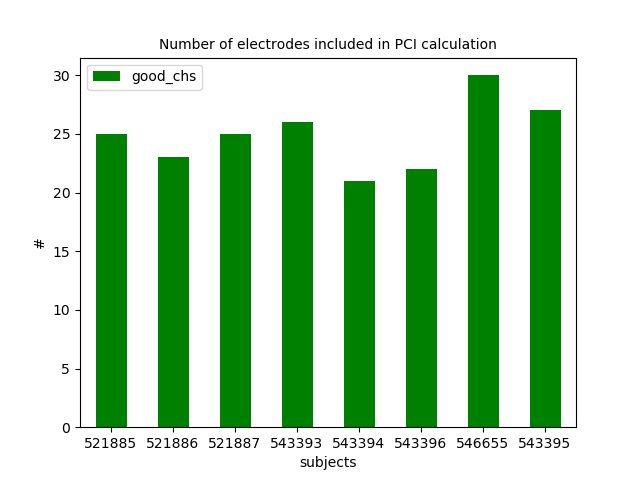

Text(0, 0.5, '#')

In [43]:
numchsax = numchsdf.plot.bar(x='subjects', y='good_chs', rot=0, color='g')
numchsax.set_title('Number of electrodes included in PCI calculation')
numchsax.set_ylabel('#')

In [49]:
## Number of PCs ##
numPCs = {}
for mousei in full_PCI_output.keys():
    numPCs[mousei] = {}
    for statei in full_PCI_output[mousei].keys():
        numPCs[mousei][statei] = full_PCI_output[mousei][statei]['n_dims']
pcdf = pd.DataFrame(numPCs)
pcdf.head()

,521885,521886,521887,543393,543394,543396,546655,543395
awake,4,3,4,5,4,5,4,4
anesthetized,4,2,3,5,3,4,4,6


<IPython.core.display.Javascript object>


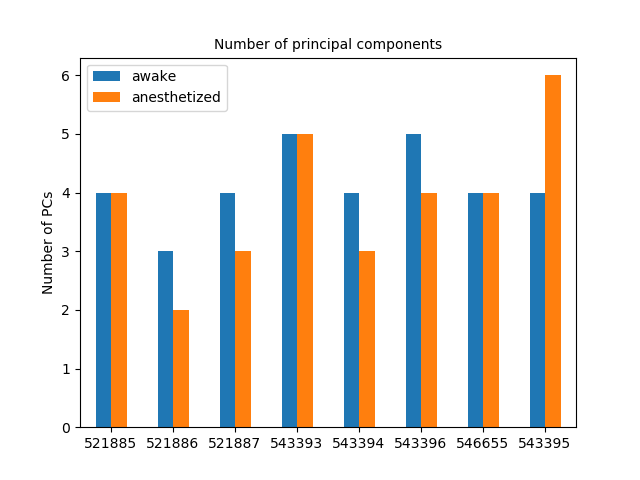

Text(0, 0.5, 'Number of PCs')

In [53]:
pcax = pcdf.T.plot.bar(rot=0)
pcax.set_title('Number of principal components')
pcax.set_ylabel('Number of PCs')

In [63]:
## State transitions ##
state_trans = {}
for mousei in full_PCI_output.keys():
    state_trans[mousei] = {}
    for statei in full_PCI_output[mousei].keys():
        state_trans[mousei][statei] = full_PCI_output[mousei][statei]['dNST']
state_trans = pd.DataFrame(state_trans)
state_trans.head()

,521885,521886,521887,543393,543394,543396,546655,543395
awake,"[9.15205704736733, 6.203734778310154, 10.42098...","[8.43370318609337, 10.292494441047074, 9.89278...","[8.813151563753006, 2.947072975140337, 11.3147...","[9.14514835605453, 9.017690321663512, 11.37859...","[8.115994268888329, 5.602204601324243, 6.49224...","[6.8609272584577745, 8.142622277440216, 8.9245...","[8.385939888004387, 6.807509636787066, 8.28900...","[10.211723514887408, 13.329314889141237, 12.06..."
anesthetized,"[4.865276663993584, 6.174193249943849, 3.79359...","[4.107691506953968, 2.279496711115553]","[2.2670408981555736, 4.467438616733415, 2.7254...","[5.296607219753444, 2.3155357238536194, 1.4030...","[4.463512429831596, 2.135707227177573, 4.39405...","[5.1436859434042095, 2.217321571772253, 1.9374...","[3.0529270248596636, 4.099503718317453, 3.1059...","[3.6135162673206627, 9.386990514784793, 11.639..."


<IPython.core.display.Javascript object>


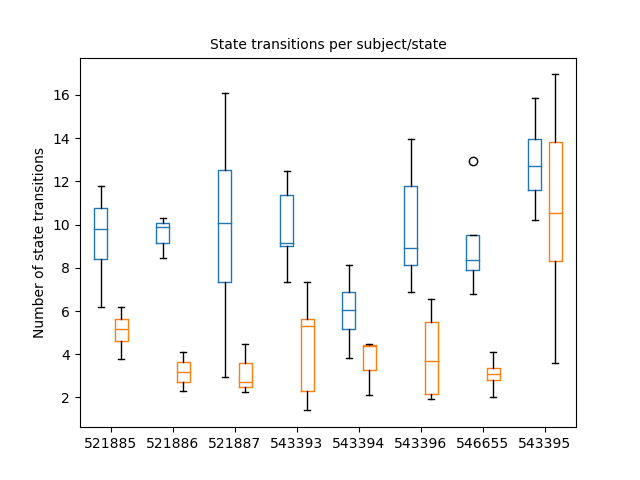

Text(0.5, 1.0, 'State transitions per subject/state')

In [76]:
fig, ax = plt.subplots()

start = 1
for ii, subject in enumerate(sub_list):
    for jj, statei in enumerate(state_trans[subject].keys()):
        if statei == 'awake':
            boxc = '#1f77b4'
        else:
            boxc = '#ff7f0e'
        ax.boxplot(
            state_trans[subject][statei],
            positions=[start],
            widths=0.6,
            boxprops=dict(color=boxc),
            medianprops=dict(color=boxc)
        )
        start += 1
    start += 1

ax.set_xlim(0,start-1)
ax.set_xticklabels(sub_list)
ax.set_xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 22.5])
ax.set_ylabel('Number of state transitions')
ax.set_title('State transitions per subject/state')